In [1]:
from google.colab import drive

# Try explicitly authorizing the connection
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import tensorflow as tf
import tensorflow.keras.layers as tfl
import PIL
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, Rescaling

In [3]:
data_dir = pathlib.Path('drive/MyDrive/dataset/')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

327


In [4]:
def plot_stats(*args):

  acc = []
  val_acc = []
  loss = []
  val_loss = []
  epochs = 0
  epoch_list = []

  for history in args:
    assert hasattr(history, 'history'), f"Object {history} is not a History object."

    acc += history.history['accuracy']
    val_acc += history.history['val_accuracy']
    loss += history.history['loss']
    val_loss += history.history['val_loss']
    epoch_list.append(epochs + len(history.history['accuracy']))
    epochs += len(history.history['accuracy'])

  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(acc, label='Training accuracy')
  plt.plot(val_acc, label='Validation accuracy')
  plt.ylim([min(plt.ylim()),1])
  for x in epoch_list[:-1]:
    plt.plot([x, x], plt.ylim())
  plt.legend(loc='upper left')
  plt.ylabel('Accuracy')
  plt.xlim([0, epochs])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2,1,2)
  plt.plot(loss, label='Training loss')
  plt.plot(val_loss, label='Validation loss')
  plt.legend(loc='upper left')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.])
  plt.xlim([0, epochs])
  for x in epoch_list[:-1]:
    plt.plot([x, x], plt.ylim())
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')

shape of the image: (685, 1024, 3)


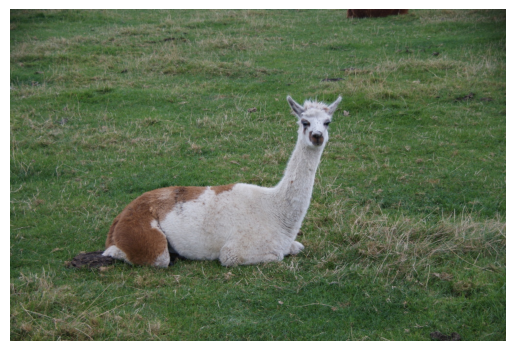

In [5]:
# plot a random image from the dataset and print its shape
r = np.random.randint(0, 100)
alpaca = list(data_dir.glob('alpaca/*'))
im = PIL.Image.open(str(alpaca[r]))
print("shape of the image:", np.array(im).shape)
plt.imshow(im)
plt.axis('off')
plt.show()

In [6]:
# parameters for the loader
batch_size = 32
img_height = 160
img_width = 160

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print("number of classes:", num_classes)

['alpaca', 'not alpaca']
number of classes: 2


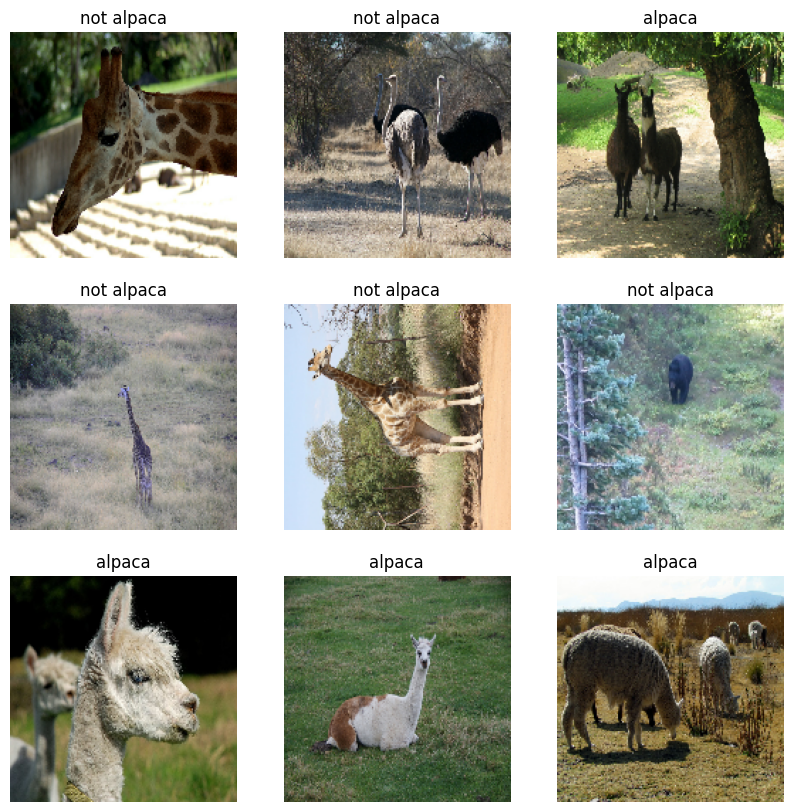

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# data augumentation
data_augumentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1)
])

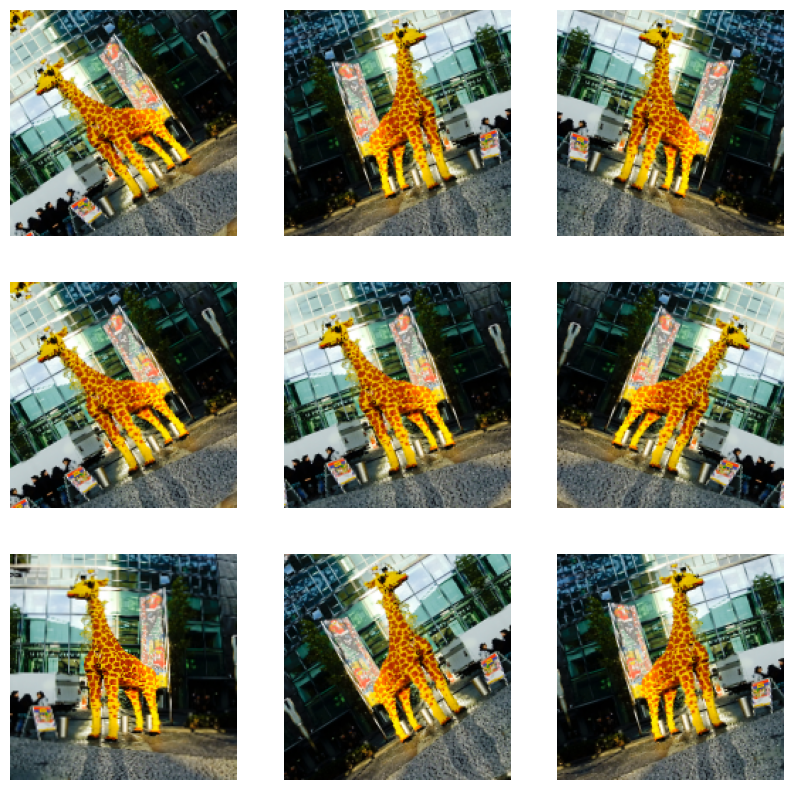

In [12]:
plt.figure(figsize=(10, 10))
for image, _ in train_ds.take(1):
  first_image = image[5]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augumented_image = data_augumentation(tf.expand_dims(first_image, 0))
    plt.imshow(augumented_image[0]/255.)
    plt.axis("off")

In [13]:
image_shape = (img_height, img_width, 3)
base_model = tf.keras.applications.MobileNetV2(
  input_shape=image_shape,
  include_top=False,
  weights='imagenet')

base_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [14]:
# printing dimensions of the last layer
image_batch, labels_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [15]:
base_model = tf.keras.applications.MobileNetV2(
              input_shape=image_shape,
              include_top=False,
              weights='imagenet')

base_model.trainable = False

inputs = tf.keras.Input(shape=image_shape)
x = data_augumentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [16]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
init_epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=init_epochs)

Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.7097 - loss: 0.6206 - val_accuracy: 0.7846 - val_loss: 0.4323
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8566 - loss: 0.3571 - val_accuracy: 0.8615 - val_loss: 0.2747
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8797 - loss: 0.2468 - val_accuracy: 0.9231 - val_loss: 0.2246
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9300 - loss: 0.2144 - val_accuracy: 0.9385 - val_loss: 0.1702
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8799 - loss: 0.2450 - val_accuracy: 0.9231 - val_loss: 0.1842


In [18]:
base_model.trainable = True
epochs = init_epochs + 5
model.compile(optimizer=tf.keras.optimizers.Adam(0.1*base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history2 = model.fit(train_ds, validation_data=val_ds, epochs=epochs, initial_epoch=history.epoch[-1])

Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 459ms/step - accuracy: 0.7899 - loss: 0.7574 - val_accuracy: 0.9231 - val_loss: 0.2254
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.9517 - loss: 0.1380 - val_accuracy: 0.9231 - val_loss: 0.3109
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9378 - loss: 0.1336 - val_accuracy: 0.9231 - val_loss: 0.3655
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.9581 - loss: 0.0800 - val_accuracy: 0.9231 - val_loss: 0.3705
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9906 - loss: 0.0350 - val_accuracy: 0.9385 - val_loss: 0.3537
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.9973 - loss: 0.0314 - val_accuracy: 0.9385 - val_loss: 0.3528


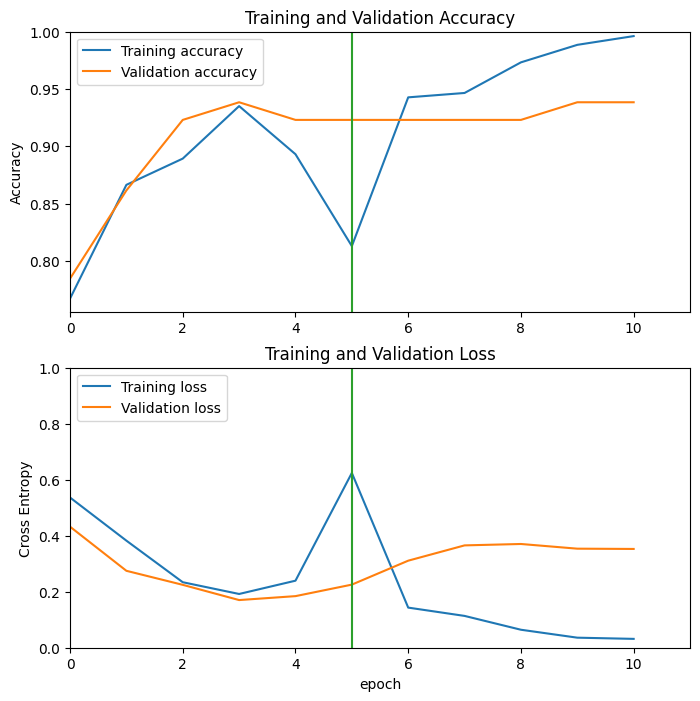

In [19]:
plot_stats(history, history2)

In [20]:
history.epoch[-1]

4